In [1]:
# installing necessary packages
import pandas as pd
import nfl_data_py as nfl
import statsmodels.formula.api as smf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns

<h2>Passing</h2>

In [2]:
seasons = range(2020,2023+1)
pbp_passing = nfl.import_pbp_data(seasons)

pbp_passer = pbp_passing[
    (pbp_passing['play_type'] == 'pass') & 
    (pbp_passing['air_yards'].notnull()) &
    (pbp_passing['air_yards'] != 0)]

pbp_py_p = pbp_passer.groupby(['passer_id', 'passer'], as_index = False).agg({'air_yards': ['count', 'mean']})

# flattens the dataframe, eliminates multilevel index
pbp_py_p.columns = list(map('_'.join, pbp_py_p.columns.values))

# grabs only the passers who threw more than 50 times
pbp_py_p = pbp_py_p[pbp_py_p['air_yards_count'] > 50]

pbp_py_p.sort_values('air_yards_mean',ascending=False)[:10]

2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


,passer_id_,passer_,air_yards_count,air_yards_mean
210,00-0039152,W.Levis,246,10.926829
67,00-0032268,M.Mariota,334,10.703593
59,00-0031503,J.Winston,316,10.585443
145,00-0035704,D.Lock,594,9.491582
183,00-0036945,J.Fields,908,9.355727
12,00-0026158,J.Flacco,591,9.343486
170,00-0036389,J.Hurts,1639,9.230628
127,00-0034899,J.Wolford,102,9.225490
211,00-0039163,C.Stroud,533,9.213884
82,00-0033275,P.Walker,318,9.169811


In [3]:
# np.where takes a condition, x, and y. If condition is met, swaps value for x, otherwise y
pbp_passer['pass_length_air_yards'] = np.where(pbp_passer['air_yards'] >= 20, 'long', 'short')

pbp_passer['passing_yards'] = np.where(pbp_passer['passing_yards'].isnull(), 0, pbp_passer['passing_yards'])

pbp_passer['passing_yards'].describe()

C:\Users\caesa\AppData\Local\Temp\ipykernel_7644\3620367151.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_passer['pass_length_air_yards'] = np.where(pbp_passer['air_yards'] >= 20, 'long', 'short')
C:\Users\caesa\AppData\Local\Temp\ipykernel_7644\3620367151.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pbp_passer['passing_yards'] = np.where(pbp_passer['passing_yards'].isnull(), 0, pbp_passer['passing_yards'])


count    72787.000000
mean         7.281589
std          9.654245
min        -20.000000
25%          0.000000
50%          5.000000
75%         11.000000
max         98.000000
Name: passing_yards, dtype: float64

In [4]:
pbp_passer[pbp_passer['pass_length_air_yards'] == 'long']['passing_yards'].describe()

count    8818.000000
mean       12.289635
std        17.810510
min         0.000000
25%         0.000000
50%         0.000000
75%        26.000000
max        98.000000
Name: passing_yards, dtype: float64

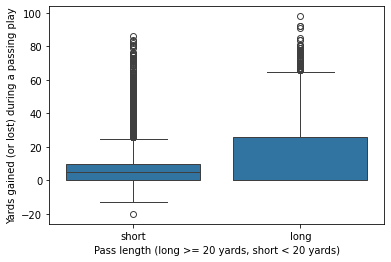

In [5]:
pass_boxplot = sns.boxplot(data=pbp_passer,x='pass_length_air_yards',y='passing_yards')

pass_boxplot.set(
 xlabel='Pass length (long >= 20 yards, short < 20 yards)',
 ylabel='Yards gained (or lost) during a passing play',
);
plt.show();

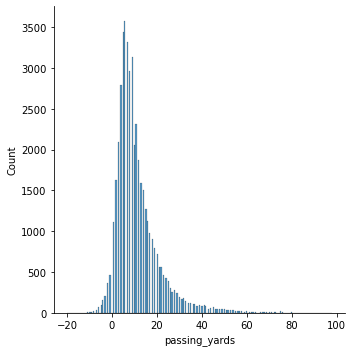

In [6]:
pbp_passing_view = pbp_passer[pbp_passer['passing_yards'] != 0]
sns.displot(data=pbp_passing_view, x='passing_yards')
plt.show()

In [7]:
# grouping by passer/season
pbp_top_passer = pbp_passer.groupby(['passer_id','home_team', 'passer', 'season']).agg({'passing_yards': ['mean', 'count']})

pbp_top_passer.columns = list(map('_'.join, pbp_top_passer.columns.values))

pbp_top_passer.rename(columns={'passing_yards_mean': 'ypa','passing_yards_count': 'num_attempts'},inplace=True)
pbp_top_passer

pbp_top_passer.sort_values(by=['ypa'], ascending=False).head()

pbp_top_passer = pbp_top_passer.query('num_attempts >= 100').sort_values(by=['ypa'], ascending=False)


# top passers by ypa over the past couple of seasons(2024 excluded)
pbp_top_passer.head(13)

,,,,ypa,num_attempts
passer_id,home_team,passer,season,,
00-0037834,SF,B.Purdy,2023,10.090909,253
00-0036442,CIN,J.Burrow,2021,9.420613,359
00-0039163,HOU,C.Stroud,2023,9.411765,289
00-0036212,MIA,T.Tagovailoa,2022,9.303571,168
00-0034796,BAL,L.Jackson,2023,9.154135,266
00-0033077,DAL,D.Prescott,2020,9.093220,118
00-0033537,HOU,D.Watson,2020,9.089286,280
00-0035100,CIN,J.Browning,2023,8.841121,107
00-0029604,MIN,K.Cousins,2020,8.777778,252


<h2>Rushing</h2>

In [8]:
pbp_rushing = nfl.import_pbp_data(seasons)

2020 done.
2021 done.
2022 done.
2023 done.
Downcasting floats.


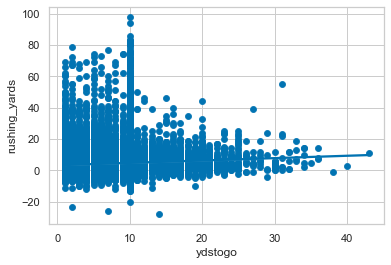

In [9]:
pbp_rushing = pbp_rushing[
    (pbp_rushing['play_type'] == 'run') & 
    (pbp_rushing['rushing_yards'].notnull()) &
    (pbp_rushing['down'].notnull())]

pbp_rushing.loc[pbp_rushing.rushing_yards.isnull(), 'rushing_yards'] = 0

sns.set_theme(style='whitegrid', palette='colorblind')
sns.scatterplot(data=pbp_rushing, x='ydstogo', y='rushing_yards');
sns.regplot(data=pbp_rushing, x='ydstogo', y='rushing_yards');
plt.show();
# very slight positive increase between yards that the rusher has to go for a first down and how many yards the rusher makes
# other approach would be to bin and average by yards to go

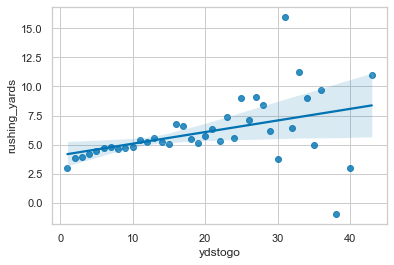

In [10]:
pbp_rushing_avg = pbp_rushing.groupby(['ydstogo']).agg({'rushing_yards': pd.Series.mean, 'defenders_in_box':pd.Series.mean})


# pbp_rushing_avg.columns = \
#  list(map('_'.join, pbp_rushing_avg.columns))

pbp_rushing_avg
pbp_rushing_avg\
 .reset_index(inplace=True)

sns.regplot(data=pbp_rushing_avg, x='ydstogo', y='rushing_yards');
plt.show();

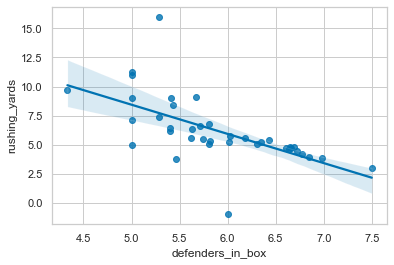

In [11]:
sns.regplot(data=pbp_rushing_avg, x='defenders_in_box', y='rushing_yards');
plt.show();

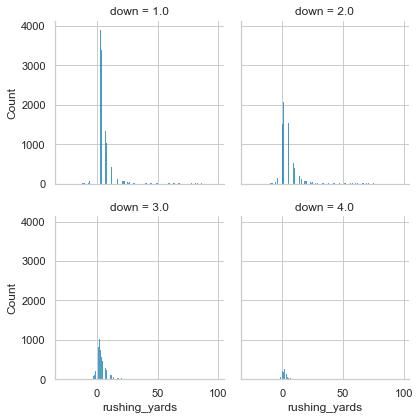

In [12]:
pbp_rushing['down'] =pbp_rushing['down'].astype(str)
# Plot rushing yards by down
graph = sns.FacetGrid(data=pbp_rushing,col='down', col_wrap=2);
graph.map_dataframe(sns.histplot, x='rushing_yards');
plt.show();

# much greater sample size on first down, however there is a very slight change in yards gained

In [13]:
# smf module most intuitive way to run a regression in python
# utilizing the discussed variables as IVs, adding interaction variable between ydstogo and the down, as each scenario should provide a different avg rushing yards
expected_yards_rushing = smf.ols(data=pbp_rushing, formula='rushing_yards ~ 1 + down + defenders_in_box + ydstogo + down:ydstogo').fit()

# fit the regression to 
pbp_rushing['ryoe'] =expected_yards_rushing.resid

print(expected_yards_rushing.summary())

                            OLS Regression Results                            
Dep. Variable:          rushing_yards   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     180.5
Date:                Wed, 15 Jan 2025   Prob (F-statistic):          1.26e-302
Time:                        14:30:56   Log-Likelihood:            -1.8024e+05
No. Observations:               55967   AIC:                         3.605e+05
Df Residuals:                   55958   BIC:                         3.606e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.1100    

In [14]:
# calculating rushing yards over expected for each rusher
ryoe_pbp =pbp_rushing.groupby(['season','home_team', 'rusher_id', 'rusher'],as_index = False).agg({'ryoe': ['count', 'sum', 'mean'],'rushing_yards': ['mean']})

# for ease of accessing every specific aggregation
ryoe_pbp.columns =\
 list(map('_'.join, ryoe_pbp.columns))

ryoe_pbp.reset_index(inplace=True)

ryoe_pbp =ryoe_pbp.rename(columns={'ryoe_count': 'n','ryoe_sum': 'ryoe_total','ryoe_mean': 'ryoe_per','rushing_yards_mean': 'yards_per_carry'})

ryoe_pbp = ryoe_pbp[ryoe_pbp['n'] > 50]

ryoe_pbp.sort_values('ryoe_total', ascending=False)[:15]

# sorting by total accounts for sustained performance

,index,season_,home_team_,rusher_id_,rusher_,n,ryoe_total,ryoe_per,yards_per_carry
467,467,2020,GB,00-0033293,A.Jones,128,300.128108,2.344751,6.796875
1936,1936,2021,IND,00-0036223,J.Taylor,167,240.089080,1.437659,5.814371
4983,4983,2023,MIA,00-0039040,D.Achane,56,220.616993,3.939589,8.158730
839,839,2020,MIN,00-0033893,D.Cook,157,198.219458,1.262544,5.509554
307,307,2020,CLE,00-0034791,N.Chubb,111,188.600916,1.699107,5.945946
5299,5299,2023,SF,00-0033280,C.McCaffrey,157,148.441756,0.945489,5.159236
3216,3216,2022,GB,00-0033293,A.Jones,132,147.955683,1.120876,5.689394
2811,2811,2022,ATL,00-0037263,T.Allgeier,111,135.213690,1.218141,5.387387
99,99,2020,BAL,00-0034184,G.Edwards,65,132.385453,2.036699,6.184615
113,113,2020,BAL,00-0036158,J.Dobbins,75,127.871776,1.704957,6.093333


<h2>Receiver Clustering</h2>

In [50]:
df = nfl.import_weekly_data([2023])
df.head()

Downcasting floats.


,player_id,player_name,player_display_name,position,position_group,headshot_url,recent_team,season,week,season_type,...,receiving_first_downs,receiving_epa,receiving_2pt_conversions,racr,target_share,air_yards_share,wopr,special_teams_tds,fantasy_points,fantasy_points_ppr
0,00-0023459,A.Rodgers,Aaron Rodgers,QB,QB,https://static.www.nfl.com/image/upload/f_auto...,NYJ,2023,1,REG,...,0.0,NaN,0,NaN,NaN,NaN,NaN,0.0,0.0,0.0
1,00-0024243,M.Lewis,Marcedes Lewis,TE,TE,https://static.www.nfl.com/image/private/f_aut...,CHI,2023,4,REG,...,0.0,0.483465,0,0.0,0.031250,-0.012397,0.038197,0.0,0.8,1.8
2,00-0024243,M.Lewis,Marcedes Lewis,TE,TE,https://static.www.nfl.com/image/private/f_aut...,CHI,2023,7,REG,...,1.0,1.437224,0,3.2,0.034483,0.094340,0.117762,0.0,1.6,2.6
3,00-0024243,M.Lewis,Marcedes Lewis,TE,TE,https://static.www.nfl.com/image/private/f_aut...,CHI,2023,11,REG,...,0.0,-0.547367,0,0.0,0.045455,0.036885,0.094001,0.0,0.0,0.0
4,00-0024243,M.Lewis,Marcedes Lewis,TE,TE,https://static.www.nfl.com/image/private/f_aut...,CHI,2023,14,REG,...,0.0,-0.190257,0,0.0,0.033333,-0.012987,0.040909,0.0,0.4,1.4


In [16]:
pbp = nfl.import_pbp_data([2023])

passing = pbp[ pbp['pass_attempt'] == 1]
passing.head()

columns = ['week','possession_team','down','passer_player_name','pass_attempt','rush_attempt','fumble','touchdown','receiver_player_name','receiver_player_id','rusher_player_name','rushing_yards','complete_pass','passing_yards','ngs_air_yards','season','time_to_throw','route']

fb = pbp[columns]

2023 done.
Downcasting floats.


In [17]:
fb = fb[fb['week'] < 19]
fb[-50:]

# number of times every receiver was targeted by week
receiver_targets = fb[fb['pass_attempt'] == 1]

receiver_targets = fb.groupby(['week','receiver_player_name','receiver_player_id'],as_index = False).agg({'passing_yards':pd.Series.sum,'pass_attempt':pd.Series.count,'complete_pass':pd.Series.sum,'ngs_air_yards':pd.Series.mean})

# receiver_targets = fb.groupby(['week','possession_team','receiver_player_id'],as_index = False).agg({'passing_yards':pd.Series.sum,'pass_attempt':pd.Series.count,'complete_pass':pd.Series.sum,'ngs_air_yards':pd.Series.mean})
receiver_targets.sort_values('complete_pass',ascending=False)

# identified that grouped based solely on receiver name isn't the best solution, e.g. Tyreek Hill vs Taysom Hill
# tyreek = receiver_targets[receiver_targets['receiver_player_id'] == '00-0033040']
# tyreek[:20]

# ran into an error where certain weeks werent showing up for receivers, for some reason some of the teams aren't coded in as possessing, removed

,week,receiver_player_name,receiver_player_id,passing_yards,pass_attempt,complete_pass,ngs_air_yards
643,3,K.Allen,00-0030279,215.0,20,18.0,5.876500
1122,5,J.Chase,00-0036900,192.0,19,15.0,9.118947
440,2,P.Nacua,00-0039075,147.0,20,15.0,6.228000
2803,12,K.Allen,00-0030279,120.0,16,14.0,6.221250
766,4,A.Kamara,00-0033906,33.0,14,13.0,-1.558571
...,...,...,...,...,...,...,...
2589,11,M.Valdes-Scantling,00-0034272,0.0,3,0.0,28.323334
2594,11,N.Gray,00-0036637,0.0,1,0.0,6.210000
2598,11,O.Zaccheaus,00-0035208,0.0,1,0.0,-4.440000
2618,11,S.Jackson,00-0038891,0.0,1,0.0,28.799999


In [18]:
# avgTargets = receiver_targets.groupby(['receiver_player_name','receiver_player_id'],as_index = False).agg({'passing_yards':pd.Series.sum, 'complete_pass':pd.Series.mean, 'pass_attempt':pd.Series.mean,'ngs_air_yards':pd.Series.mean})
avgTargets = receiver_targets.groupby(['receiver_player_name','receiver_player_id'],as_index = False).agg({'passing_yards':pd.Series.sum, 'complete_pass':pd.Series.mean, 'pass_attempt':pd.Series.mean})
avgTargets = avgTargets.sort_values('passing_yards',ascending=False)
avgTargets = avgTargets.rename(columns = {'receiver_player_id':'player_gsis_id'})
# avgTargets['fantasy_pts'] = avgTargets['passing

avgTargets[:20]

receivingStats = nfl.import_ngs_data('receiving', [2023])
receivingStats.sort_values(by=['avg_separation'], ascending = False, inplace = True)
receivingStats = receivingStats[receivingStats['season_type'] == 'REG']

receivingStats = receivingStats.groupby(['player_display_name','player_gsis_id','player_position','team_abbr'],as_index=False).agg({'avg_cushion':pd.Series.mean,'avg_separation':pd.Series.mean,'avg_intended_air_yards':pd.Series.mean,'percent_share_of_intended_air_yards':pd.Series.mean,'avg_yac':pd.Series.mean,'avg_yac_above_expectation':pd.Series.mean})
receivingStats

,player_display_name,player_gsis_id,player_position,team_abbr,avg_cushion,avg_separation,avg_intended_air_yards,percent_share_of_intended_air_yards,avg_yac,avg_yac_above_expectation
0,A.J. Brown,00-0035676,WR,PHI,6.725555,2.519405,12.135434,44.691613,4.431081,1.657915
1,Adam Thielen,00-0030035,WR,CAR,6.301934,3.015319,7.710639,28.742956,3.414781,-0.945365
2,Adam Trautman,00-0036422,TE,DEN,4.991667,4.411217,5.229000,16.101340,2.826000,-1.302316
3,Alec Pierce,00-0037664,WR,IND,5.997849,2.344480,14.677038,28.930521,2.725885,-0.177712
4,Alex Erickson,00-0032543,WR,LAC,6.632024,2.549214,9.590071,21.235920,5.390476,0.860080
...,...,...,...,...,...,...,...,...,...,...
199,Will Mallory,00-0038394,TE,IND,9.215000,3.534384,4.778000,10.409586,4.422000,-0.748973
200,Xavier Gipson,00-0038496,WR,NYJ,5.350083,3.071812,10.179226,25.450210,6.118125,0.175499
201,Zach Ertz,00-0030061,TE,ARI,6.674854,2.834784,7.631938,24.700150,2.093333,-0.096268
202,Zay Flowers,00-0039064,WR,BAL,7.973793,3.668876,8.494853,26.231387,4.457204,0.491382


In [19]:
# join both tabled
mergedStats = pd.merge(avgTargets,receivingStats,on='player_gsis_id')
mergedStats = mergedStats.sort_values('percent_share_of_intended_air_yards',ascending=False)
# mergedStats[:30]

In [20]:
combine = nfl.import_combine_data([2023,2022,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010])
combine.sort_values('draft_year',ascending = False)
combine = combine.rename(columns={'player_name':'player_display_name'})
combine = combine[['player_display_name','forty']]

# fillna with average forty time
fortymean = combine['forty'].mean()
combine['forty'].fillna(fortymean, inplace = True)


In [21]:
ids = nfl.import_ids()
ids = ids[['gsis_id','height','weight','age']]
ids = ids.rename(columns = {'gsis_id':'player_gsis_id'})
mergedStats = pd.merge(mergedStats,ids,on='player_gsis_id')
mergedStats = pd.merge(mergedStats,combine,on='player_display_name')
mergedStats[:50]

player_names = mergedStats['receiver_player_name']

stat_columns = ['avg_cushion','avg_separation','avg_intended_air_yards','avg_yac','weight','age','forty']



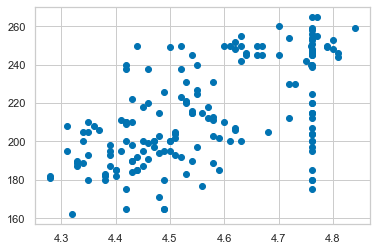

In [22]:
plt.scatter(mergedStats['forty'],mergedStats['weight'])

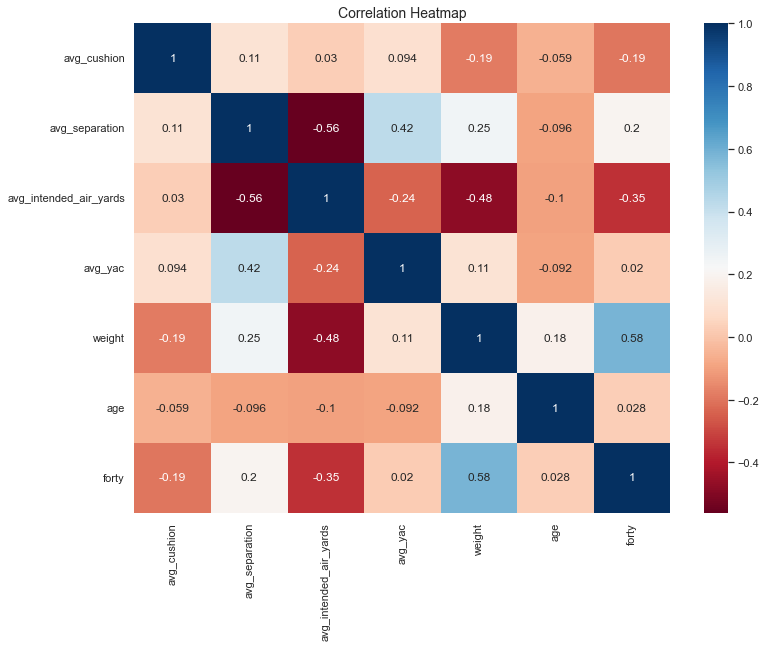

In [23]:
stats = mergedStats[stat_columns]

plt.figure(figsize=(12,9))
sns.heatmap(stats.corr(),annot=True,cmap='RdBu')
plt.title('Correlation Heatmap',fontsize=14)
plt.yticks(rotation =0)
plt.show()


In [24]:
scaler = StandardScaler()
stats = stats.fillna(0)
stats_std = scaler.fit_transform(stats)


In [25]:
stats_std = pd.DataFrame(data = stats_std,columns = stats.columns)
wcss = []

kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans.fit(stats_std)


KMeans(n_clusters=4, random_state=42)

In [26]:
stats_std_kmeans= stats_std.copy()
stats_std['Segment K-means'] = kmeans.labels_

stats_std_analysis = stats_std.groupby(['Segment K-means'],as_index=False).mean()
stats_std_analysis

,Segment K-means,avg_cushion,avg_separation,avg_intended_air_yards,avg_yac,weight,age,forty
0,0,-0.117210,-0.434749,0.183758,-0.314008,-0.030993,1.132477,-0.075277
1,1,-0.072538,-0.744247,0.946727,-0.433488,-0.566463,-0.681356,-0.416095
2,2,-0.362862,0.779412,-0.901619,0.341778,1.260364,-0.129448,0.985820
3,3,0.762012,0.698241,-0.470872,0.644700,-0.794293,-0.462931,-0.587094


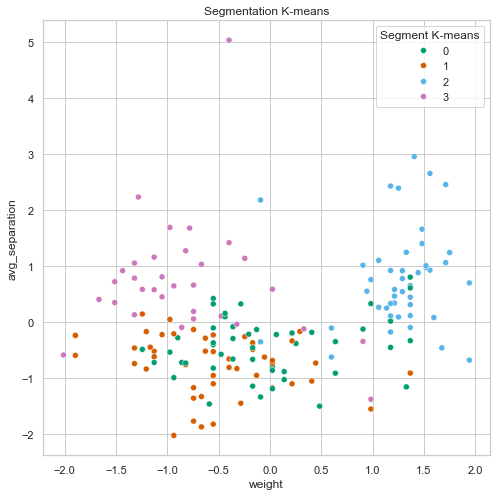

In [27]:
x_axis = stats_std['weight']
y_axis = stats_std['avg_separation']
plt.figure(figsize = (8, 8))
sns.scatterplot(x=x_axis,y=y_axis, hue = stats_std['Segment K-means'], palette = ['g', 'r', 'c', 'm'])
plt.title('Segmentation K-means')
plt.show()

In [28]:
pca = PCA()
pca.fit(stats_std)

PCA()

In [29]:
pca.explained_variance_ratio_

array([0.33083931, 0.23304415, 0.12742787, 0.09990686, 0.08133564,
       0.05095062, 0.04391023, 0.03258532])

Text(0, 0.5, 'Cumulative Explained Variance')

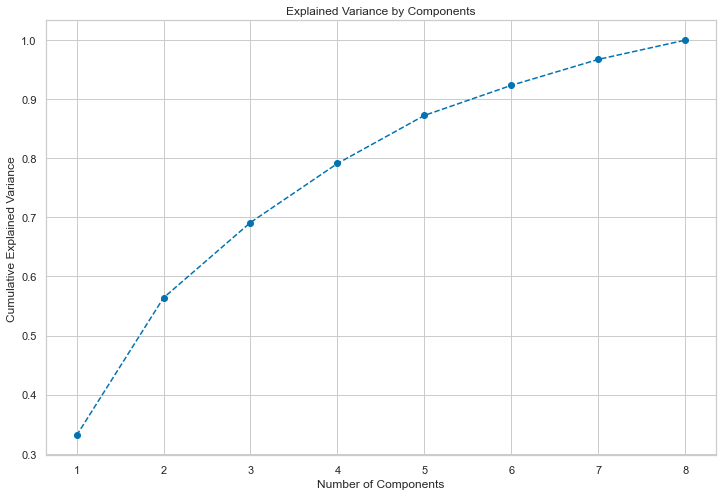

In [30]:
plt.figure(figsize = (12,8))
plt.plot(range(1,9), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [33]:
pca = PCA(n_components = 4)
pca.fit(stats_std)
pca.components_

array([[ 0.04711652,  0.4917178 , -0.47269668,  0.33936593,  0.3069509 ,
        -0.13100054,  0.26937556,  0.48315532],
       [ 0.36500492,  0.07734793,  0.19700304,  0.18247769, -0.49862644,
        -0.41940749, -0.44871434,  0.40349086],
       [ 0.50887356,  0.18101535, -0.16076872,  0.25455173, -0.03625896,
         0.6990181 , -0.30395697, -0.18790189],
       [-0.70177405,  0.09286447,  0.07093369,  0.59782376, -0.14556972,
         0.1232986 , -0.30604717, -0.0800411 ]])

In [34]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = stats_std.columns,
              index = ['Component 1', 'Component 2', 'Component 3', 'Component 4'])
df_pca_comp

,avg_cushion,avg_separation,avg_intended_air_yards,avg_yac,weight,age,forty,Segment K-means
Component 1,0.047117,0.491718,-0.472697,0.339366,0.306951,-0.131001,0.269376,0.483155
Component 2,0.365005,0.077348,0.197003,0.182478,-0.498626,-0.419407,-0.448714,0.403491
Component 3,0.508874,0.181015,-0.160769,0.254552,-0.036259,0.699018,-0.303957,-0.187902
Component 4,-0.701774,0.092864,0.070934,0.597824,-0.145570,0.123299,-0.306047,-0.080041


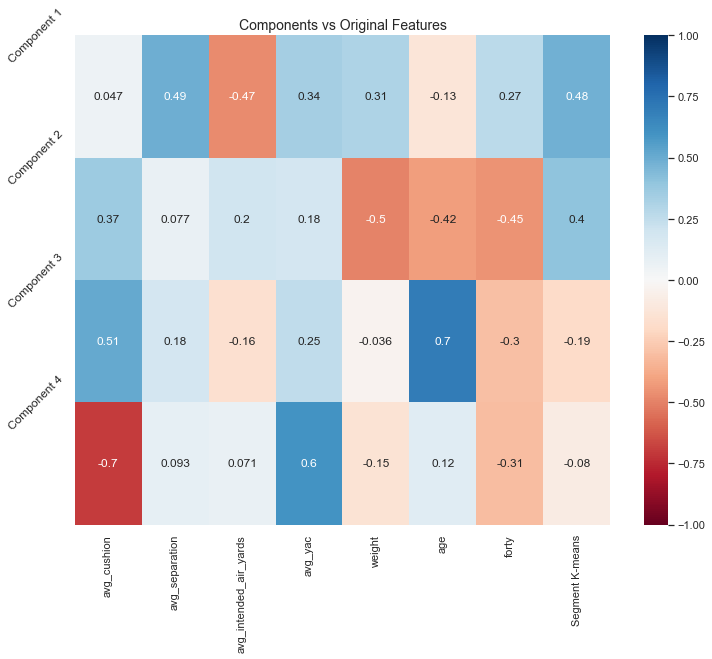

In [35]:
plt.figure(figsize=(12,9))
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1,2,3], 
           ['Component 1', 'Component 2', 'Component 3', 'Component 4'],
           rotation = 45,
           fontsize = 12)
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

In [36]:
pca.transform(stats_std)
scores_pca = pca.transform(stats_std)


In [38]:
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=42)

In [39]:
df_segm_pca_kmeans = pd.concat([stats.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-4: ] = ['Component 1', 'Component 2', 'Component 3', 'Component 4']

cluster_labels = {0:'Physical', 
           1:'Short Option',
           2:'Speedy', 
           3:'Long Option'}

df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
df_segm_pca_kmeans.head()

,avg_cushion,avg_separation,avg_intended_air_yards,avg_yac,weight,age,forty,Component 1,Component 2,Component 3,Component 4,Segment K-means PCA
0,6.441333,2.607031,26.451556,3.428333,185.0,23.3,4.40,-3.112652,2.270495,-1.361645,0.185930,3
1,7.507500,3.737680,6.630000,8.403333,187.0,26.8,4.33,1.452662,2.667410,1.424912,0.604789,0
2,5.415731,2.434369,10.455540,4.633765,183.0,24.5,4.38,-1.296147,1.088829,-0.829064,1.046285,3
3,7.422000,2.263980,17.336667,6.390000,225.0,24.8,4.55,-1.080562,0.966675,-0.215771,-0.421614,3
4,5.216490,2.472674,10.621177,3.249650,215.0,32.0,4.56,-1.632558,-1.718101,0.503179,0.694122,1


In [40]:
# We calculate the means by segments.
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,avg_cushion,avg_separation,avg_intended_air_yards,avg_yac,weight,age,forty,Component 1,Component 2,Component 3,Component 4
Segment K-means PCA,,,,,,,,,,,
0,7.062091,3.647370,7.560523,5.956771,195.029412,25.991176,4.486039,1.294499,1.830123,0.344906,-0.095379
1,6.152169,2.753706,10.238641,3.811901,213.583333,30.631250,4.555342,-1.246182,-1.070509,0.822667,0.142940
2,5.839449,3.719266,5.965097,5.331543,247.418605,27.002326,4.715256,1.886378,-0.975143,-0.397362,-0.020457
3,6.195086,2.508649,13.261705,3.538797,199.632653,25.369388,4.503644,-1.332866,0.634518,-0.696494,-0.055889


In [41]:
df_segm_pca_kmeans_freq['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','avg_separation']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans_freq['Prop Obs'] = df_segm_pca_kmeans_freq['N Obs'] / df_segm_pca_kmeans_freq['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans_freq.rename(cluster_labels)
df_segm_pca_kmeans_freq

,avg_cushion,avg_separation,avg_intended_air_yards,avg_yac,weight,age,forty,Component 1,Component 2,Component 3,Component 4,N Obs,Prop Obs
Segment K-means PCA,,,,,,,,,,,,,
Physical,7.062091,3.647370,7.560523,5.956771,195.029412,25.991176,4.486039,1.294499,1.830123,0.344906,-0.095379,34,0.195402
Short Option,6.152169,2.753706,10.238641,3.811901,213.583333,30.631250,4.555342,-1.246182,-1.070509,0.822667,0.142940,48,0.275862
Speedy,5.839449,3.719266,5.965097,5.331543,247.418605,27.002326,4.715256,1.886378,-0.975143,-0.397362,-0.020457,43,0.247126
Long Option,6.195086,2.508649,13.261705,3.538797,199.632653,25.369388,4.503644,-1.332866,0.634518,-0.696494,-0.055889,49,0.281609


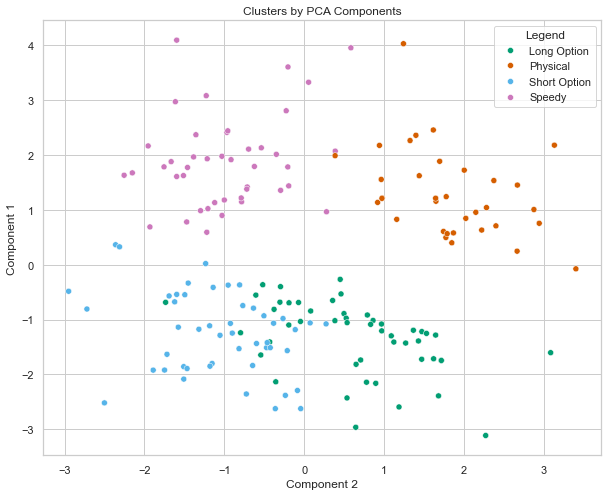

In [42]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map(cluster_labels)
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10, 8))
sns.scatterplot(x=x_axis,y= y_axis, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components')
plt.show()


In [49]:
df_segm_pca_kmeans['Player Name'] = player_names.values

df_segm_pca_kmeans.sort_values('avg_intended_air_yards',ascending=False)[:15]

,avg_cushion,avg_separation,avg_intended_air_yards,avg_yac,weight,age,forty,Component 1,Component 2,Component 3,Component 4,Segment K-means PCA,Legend,Player Name
0,6.441333,2.607031,26.451556,3.428333,185.0,23.3,4.40,-3.112652,2.270495,-1.361645,0.185930,3,Long Option,J.Hyatt
63,7.330000,3.212112,23.070000,8.380000,182.0,22.8,4.38,-1.602992,3.083273,-0.140187,0.878148,3,Long Option,M.Mims
26,5.205833,1.616408,21.186833,3.790000,197.0,26.0,4.47,-2.962899,0.644341,-1.495020,0.879056,3,Long Option,J.Reagor
29,6.695000,2.440423,19.806000,5.931667,206.0,30.3,4.37,-2.161155,0.894826,1.000668,0.757560,3,Long Option,M.Valdes-Scantling
3,7.422000,2.263980,17.336667,6.390000,225.0,24.8,4.55,-1.080562,0.966675,-0.215771,-0.421614,3,Long Option,T.Burks
56,6.874286,2.685848,17.204190,0.541333,185.0,23.8,4.40,-2.390468,1.680142,-0.940113,-1.020457,3,Long Option,T.Tucker
28,5.763863,2.226217,15.866616,2.398020,200.0,28.3,4.34,-2.428168,0.534895,-0.188645,0.426930,3,Long Option,D.Chark
32,6.678867,2.891700,15.855704,4.379704,208.0,25.7,4.36,-1.427311,1.268825,-0.008421,0.159138,3,Long Option,C.Watson
14,6.698883,2.909453,15.569774,3.635514,165.0,25.2,4.49,-1.744857,1.715235,-0.386169,-0.096439,3,Long Option,T.Dell
15,6.698883,2.909453,15.569774,3.635514,165.0,25.2,4.49,-1.744857,1.715235,-0.386169,-0.096439,3,Long Option,N.Dell


In [44]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map(cluster_labels)

In [ ]:
df_segm_pca_kmeans.to_csv('receiver_clustering.csv')